# Process NHL Player College 

Data cleaning process largely follows

* NHL player-level statistics from processed table using API using this repository's code
* NHL-college player records are from [College Hockey Inc.](https://collegehockeyinc.com/2021-22-alums-nhl.php). Rotate out the URL years to get historical records.

![this process](diagram_headline.png)

Not all college players are accounted for, who maybe reserve players or data not able to be matched. At the time of the initial analysis 1/26/2024, the match rate is about $\frac{2,119}{3,438}\approx 61.6\%$

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

cwd = os.getcwd()
cwd_git = os.path.dirname(os.path.dirname(os.path.dirname(cwd)))

import sys
sys.path.append(cwd_git)

import credentials
from credentials import cwd_data

# For the first time, run the data processing
#%run -i 'player_college_matching.py'

In [2]:
dfin = pd.read_csv(cwd_data + "nhl/data_gamelvl/data/processed/2022cum_player_collegematch.csv")
# Ignore Goalie
dfin = dfin.loc[dfin.position != "G"]
# Season to start at 2017
dfin = dfin.loc[dfin.season >= 2017]
# For plotting purpose
dfin["Draft Level"] = ["1st" if iter == "1st" else "FA" if iter=="FA" else "Lower" for iter in dfin.draft]
# fixing the draft season 
dfin["draft"] = ["7th" if iter == "9th" else iter for iter in dfin.draft]

# Analysis

## College Players by College

In [78]:
# Top 10 production college? need college column
tab_count = dfin.groupby('college').id_player.nunique().reset_index()
templot = tab_count.sort_values(by='id_player',ascending=False).head(8)

# Include the time-on-ice (median) contribution
# Exclude goalie here (which would be ~ 60 mins)
tempdf = dfin.loc[dfin.gamemin < 30,:]
tab_count = tempdf.groupby('college').gamemin.median().reset_index()
templot = pd.merge(templot,tab_count, on='college', how='left')


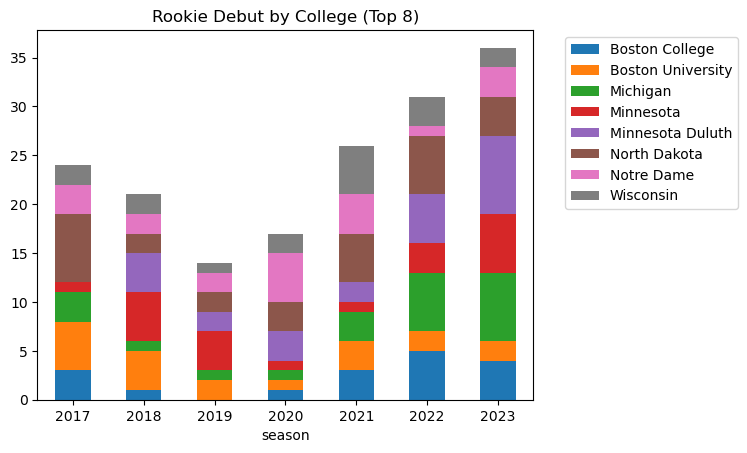

In [90]:
# Observing rookie debut
rookie = dfin.loc[dfin.rookie==True, :]\
    .groupby(['season','college'])\
    .id_player.count().reset_index()
rookie = rookie.loc[rookie.college.isin(templot.college)]

tab_rookie = rookie.pivot_table(index="season", values="id_player", columns="college").reset_index()

tab_rookie.plot(x='season', kind='bar', stacked=True,
        title='Rookie Debut by College (Top 8)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.xticks(rotation=0)

plt.savefig("./output/debut.png",  bbox_inches='tight', dpi=300)

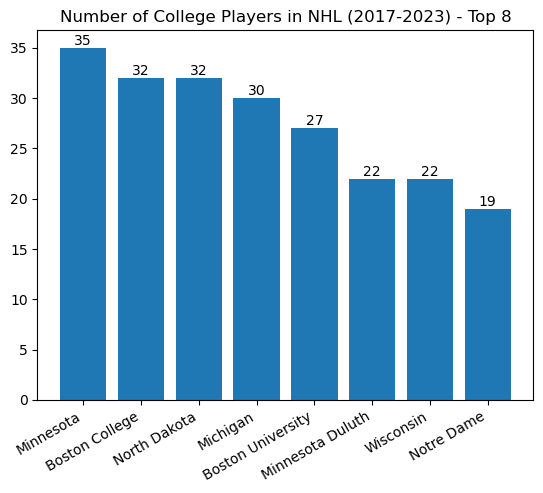

In [91]:

fig, ax = plt.subplots()
plt.bar(templot.college, templot.id_player)

ax.bar_label(ax.containers[0], label_type='edge')

plt.title("Number of College Players in NHL (2017-2023) - Top 8")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig("./output/college.png",  bbox_inches='tight', dpi=300)
plt.show()

In [3]:
import seaborn as sns
import seaborn.objects as so

Let's check how long players stick around in college, and see if there is any distinct relationship with their draft stock/status.

In [27]:
# Exploring years in college and draft status
tempdf = dfin.groupby(['id_player'])\
    .agg(
        {
            "college":"max",
            "college_yrs":"max",
            "draft":"max"
        }
    )
plotdf = tempdf.groupby(["college_yrs", "draft"]).college.count().reset_index()
plotdf.sort_values(by = ["draft", "college_yrs","college"], inplace=True)

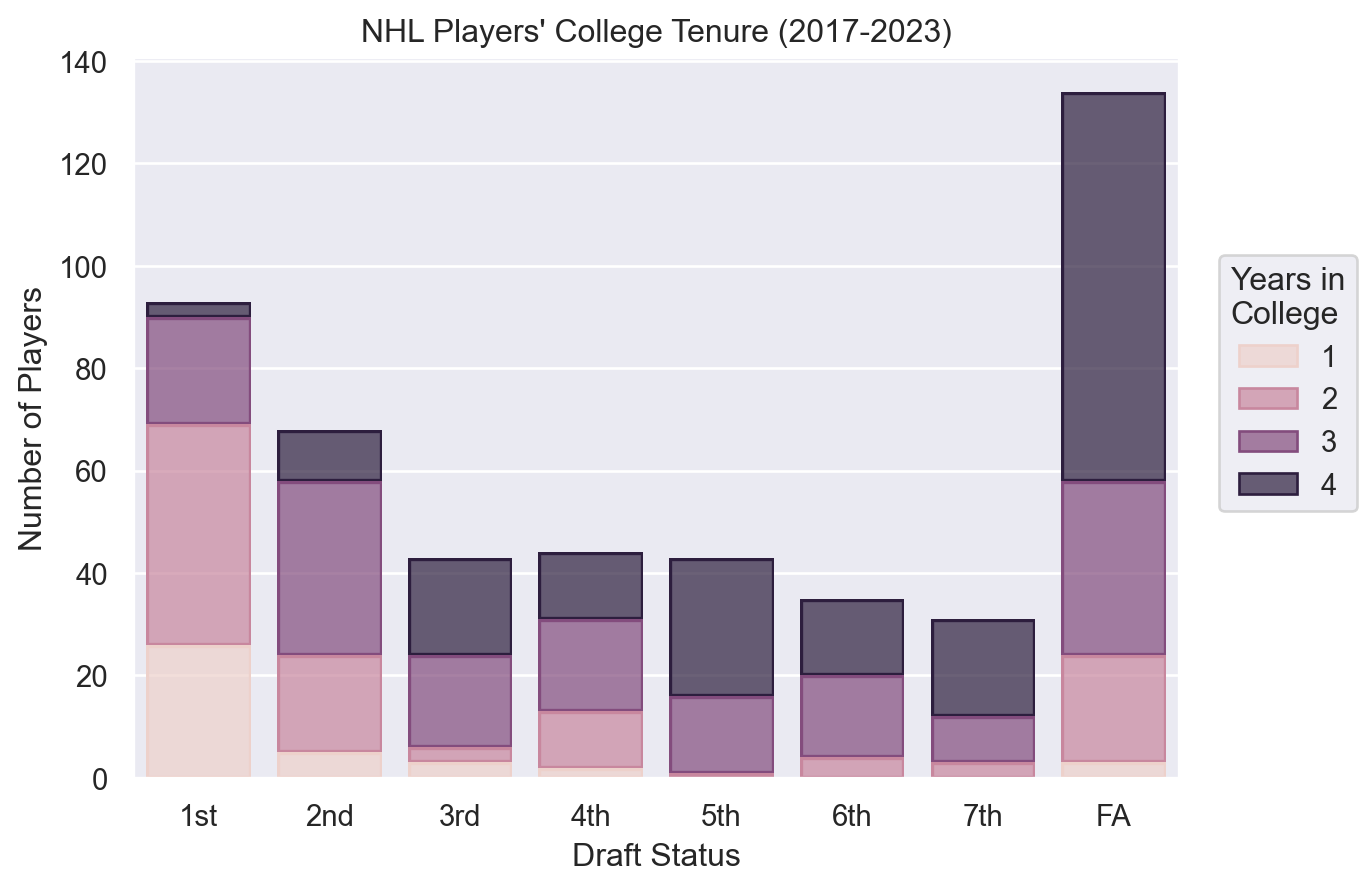

In [103]:
p = (so.Plot(plotdf, x="draft", y="college", color="college_yrs")
    .add(so.Bar(), so.Stack())
)
p = p.label(
    x="Draft Status", 
    y="Number of Players", 
    color= "Years in\nCollege",
    title="NHL Players' College Tenure (2017-2023)"
)
p.save("./output/college_draftnyrs.png",  bbox_inches='tight', dpi=300)

## Evaluating College Tenure and Production Changes
Overall, I observe that the debut/rookie season, more game time and productions are observed for those with shorter college tenure, mostly driven by highly touted/drafted player leaving college earlier in the career. 

Evaluating the non-rookie seasons (after experiences), the game time and production is consistent across players with different college tenure. This means that the production of players sorted and filtered out during their NHL debut and subsequent seasons. This also implies that leaving college tenure early is not an indiciation of better production in NHL longer-run.

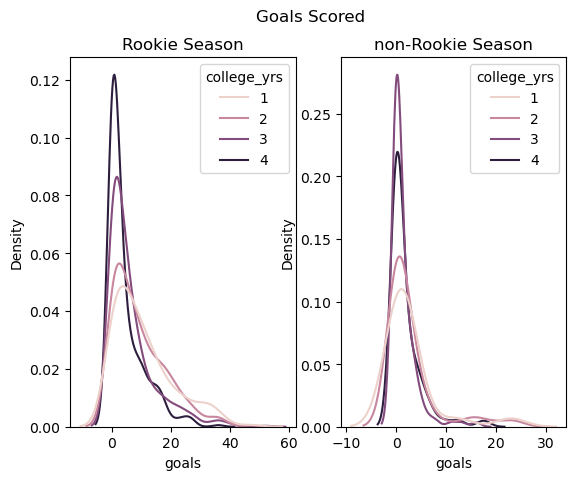

In [104]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Goals Scored')
sns.kdeplot(ax=axes[0], data=dfin.loc[dfin.rookie==False], x="goals", 
            hue="college_yrs", common_norm=False)
axes[0].set_title("Rookie Season")
sns.kdeplot(ax=axes[1], data=dfin.loc[dfin.rookie==True], x="goals", 
            hue="college_yrs", common_norm=False)
axes[1].set_title("non-Rookie Season")

fig.savefig("./output/college_yrs_goal.png",  bbox_inches='tight', dpi=300)

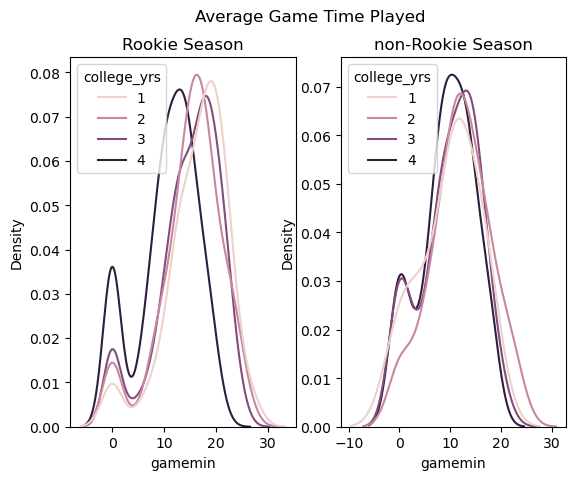

In [105]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Average Game Time Played')
sns.kdeplot(ax=axes[0], data=dfin.loc[dfin.rookie==False], x="gamemin", 
            hue="college_yrs", common_norm=False)
axes[0].set_title("Rookie Season")
sns.kdeplot(ax=axes[1], data=dfin.loc[dfin.rookie==True], x="gamemin", 
            hue="college_yrs", common_norm=False)
axes[1].set_title("non-Rookie Season")

fig.savefig("./output/college_yrs_timeonice.png",  bbox_inches='tight', dpi=300)

## Production by Draft Order
Higher draft pick players (1st round player went throuch college) are more likely to produce goals then their peers. However, as their career matures, the difference goes away. Again emphasizing that the player roaster selection is filtered and less depended on college tenure and drafts pick of the college players.

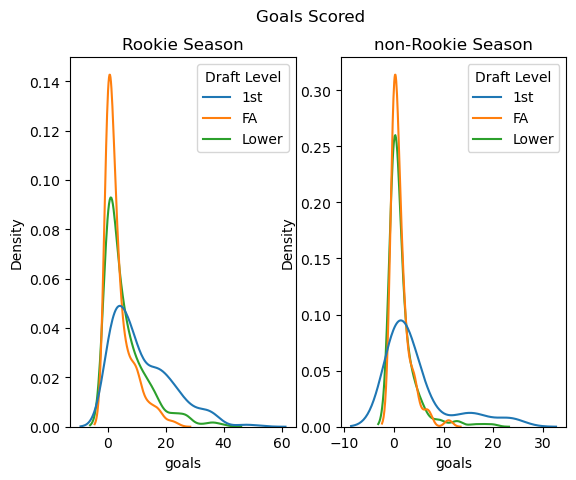

In [109]:
idx_order = sorted(dfin["Draft Level"].unique())
fig, axes = plt.subplots(1, 2)
fig.suptitle('Goals Scored')
sns.kdeplot(ax=axes[0], data=dfin.loc[dfin.rookie==False], x="goals", 
            hue="Draft Level", hue_order=idx_order, common_norm=False)
axes[0].set_title("Rookie Season")
sns.kdeplot(ax=axes[1], data=dfin.loc[dfin.rookie==True], x="goals", 
            hue="Draft Level", hue_order=idx_order, common_norm=False)
axes[1].set_title("non-Rookie Season")

fig.savefig("./output/college_draft_goals.png",  bbox_inches='tight', dpi=300)

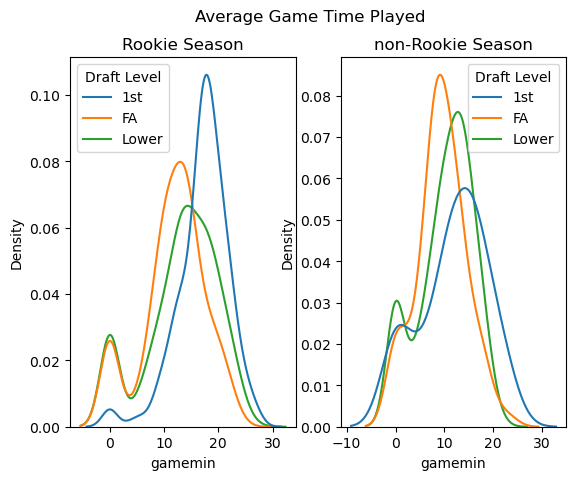

In [110]:
idx_order = sorted(dfin["Draft Level"].unique())
fig, axes = plt.subplots(1, 2)
fig.suptitle('Average Game Time Played')
sns.kdeplot(ax=axes[0], data=dfin.loc[dfin.rookie==False], x="gamemin", 
            hue="Draft Level", hue_order=idx_order, common_norm=False)
axes[0].set_title("Rookie Season")
sns.kdeplot(ax=axes[1], data=dfin.loc[dfin.rookie==True], x="gamemin", 
            hue="Draft Level", hue_order=idx_order, common_norm=False)
axes[1].set_title("non-Rookie Season")

fig.savefig("./output/college_draft_timeonice.png",  bbox_inches='tight', dpi=300)

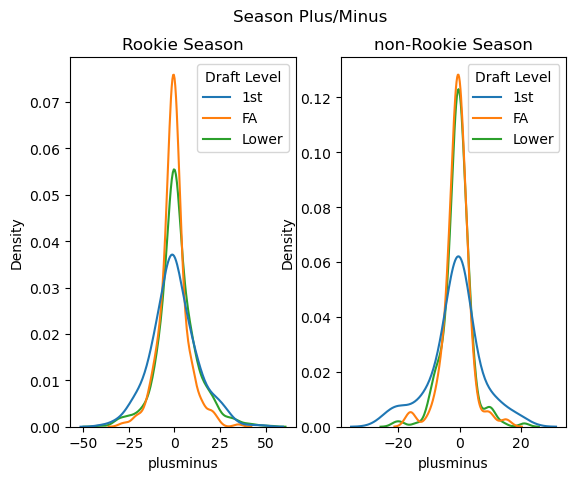

In [111]:

idx_order = sorted(dfin["Draft Level"].unique())
fig, axes = plt.subplots(1, 2)
fig.suptitle('Season Plus/Minus')
sns.kdeplot(ax=axes[0], data=dfin.loc[dfin.rookie==False], x="plusminus", 
            hue="Draft Level", hue_order=idx_order, common_norm=False)
axes[0].set_title("Rookie Season")
sns.kdeplot(ax=axes[1], data=dfin.loc[dfin.rookie==True], x="plusminus", 
            hue="Draft Level", hue_order=idx_order, common_norm=False)
axes[1].set_title("non-Rookie Season")

fig.savefig("./output/college_draft_plusminus.png",  bbox_inches='tight', dpi=300)

## Player Statistics Rank
Ranking college players by their production since 2017

In [76]:
player_stats_lt = dfin.groupby(["fullName", "draft", "college"])\
    .agg(
        {
            "position":"last",
            "rookie":"sum",
            "team_triCode": "last",
            "season":"count",
            "gamemin":"mean",
            "plusminus":"mean",
            "goals":"mean",
            "assists":"mean",
            "takeaways":"mean",
            "giveaways":"mean"
        }
    ).sort_values("goals", ascending=False)

# Count only for those who started their career in 2017
player_stats_lt = player_stats_lt.loc[player_stats_lt.rookie == 1, :].head(20)

player_stats_lt["gamemin"] = player_stats_lt["gamemin"].astype(int)
player_stats_lt["plusminus"] = player_stats_lt["plusminus"].round(1)
player_stats_lt["goals"] = player_stats_lt["goals"].round(1)
player_stats_lt["assists"] = player_stats_lt["assists"].round(1)
player_stats_lt["takeaways"] = player_stats_lt["takeaways"].round(1)
player_stats_lt["giveaways"] = player_stats_lt["giveaways"].round(1)

player_stats_lt.drop(columns="rookie", inplace=True)

player_stats_lt.reset_index(inplace=True)

player_stats_lt.columns = ["Player", "Draft", "College", "Position", "Last Team", "Seasons", "Game Minutes", "Plus-Minus", "Goals", "Assists", "Takeaways", "Giveaways"]

player_stats_lt.to_csv("./output/df_players_top_college.csv", index=False)

player_stats_lt

,Player,Draft,College,Position,Last Team,Seasons,Game Minutes,Plus-Minus,Goals,Assists,Takeaways,Giveaways
0,Kyle Connor,1st,Michigan,LW,WPG,7,18,-2.9,29.9,30.7,42.0,32.9
1,Matt Boldy,1st,Boston College,LW,MIN,2,16,9.0,23.0,28.0,39.0,32.0
2,Brock Boeser,1st,North Dakota,RW,VAN,7,17,-4.3,19.9,24.6,22.7,22.9
3,Clayton Keller,1st,Boston University,RW,ARI,7,15,-3.9,18.3,28.3,35.9,33.4
4,Tage Thompson,1st,Connecticut,C,BUF,6,12,-8.8,17.2,15.7,25.0,22.2
5,Zach Hyman,5th,Michigan,LW,EDM,7,18,7.3,16.9,20.4,25.6,21.3
6,Ross Colton,4th,Vermont,C,TBL,3,11,-0.3,15.7,12.0,24.0,10.7
7,Nick Schmaltz,1st,North Dakota,C,ARI,6,16,3.0,15.3,29.8,53.3,33.2
8,J.T. Compher,2nd,Michigan,LW,COL,7,16,-0.4,12.6,15.1,19.6,17.3
9,Troy Terry,5th,Denver,RW,ANA,6,13,-2.8,12.5,16.8,23.7,21.8
